<a href="https://colab.research.google.com/github/wyreinec/PneuX/blob/master/New_Pneux_Fix_40_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image

In [3]:
!pip install -q Kaggle
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/KaggleDatasetsAPI/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d rafyardhani/pneumonia-xray-update
#! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.70G/1.72G [00:14<00:00, 89.9MB/s]
100% 1.72G/1.72G [00:14<00:00, 125MB/s] 


In [ ]:
! unzip pneumonia-xray-update.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/00000139_001.png  
  inflating: chest_xray/train/NORMAL/00000139_002.png  
  inflating: chest_xray/train/NORMAL/00000140_000.png  
  inflating: chest_xray/train/NORMAL/00000141_000.png  
  inflating: chest_xray/train/NORMAL/00000142_000.png  
  inflating: chest_xray/train/NORMAL/00000143_001.png  
  inflating: chest_xray/train/NORMAL/00000143_003.png  
  inflating: chest_xray/train/NORMAL/00000143_004.png  
  inflating: chest_xray/train/NORMAL/00000143_005.png  
  inflating: chest_xray/train/NORMAL/00000143_010.png  
  inflating: chest_xray/train/NORMAL/00000144_000.png  
  inflating: chest_xray/train/NORMAL/00000146_000.png  
  inflating: chest_xray/train/NORMAL/00000148_000.png  
  inflating: chest_xray/train/NORMAL/00000148_003.png  
  inflating: chest_xray/train/NORMAL/00000149_000.png  
  inflating: chest_xray/train/NORMAL/00000149_001.png  
  inflating: chest_xray/train/NORMAL/00000149_003.png

In [ ]:
TRAINING_DIR = "/content/chest_xray/train"
TESTING_DIR = "/content/chest_xray/test"
VALIDATION_DIR = "/content/chest_xray/val"

TRAINING_PNEUMONIA_DIR = "/content/chest_xray/train/PNEUMONIA"
TRAINING_NORMAL_DIR = "/content/chest_xray/train/NORMAL"

TESTING_PNEUMONIA_DIR = "/content/chest_xray/test/PNEUMONIA"
TESTING_NORMAL_DIR = "/content/chest_xray/test/NORMAL"

VALIDATION_PNEUMONIA_DIR = "/content/chest_xray/val/PNEUMONIA"
VALIDATION_NORMAL_DIR = "/content/chest_xray/val/NORMAL"

uji_dir = "/uji"

print(f"\n\nThere are {len(os.listdir(TRAINING_PNEUMONIA_DIR))} images of Pneumonia for training")
print(f"There are {len(os.listdir(TRAINING_NORMAL_DIR))} images of Normal for training")
print(f"There are {len(os.listdir(TESTING_PNEUMONIA_DIR))} images of Pneumonia for testing")
print(f"There are {len(os.listdir(TESTING_NORMAL_DIR))} images of Normal for testing")
print(f"There are {len(os.listdir(VALIDATION_PNEUMONIA_DIR))} images of Pneumonia for Validating")
print(f"There are {len(os.listdir(VALIDATION_NORMAL_DIR))} images of Normal for Validating")



There are 2341 images of Pneumonia for training
There are 2341 images of Normal for training
There are 690 images of Pneumonia for testing
There are 534 images of Normal for testing
There are 233 images of Pneumonia for Validating
There are 233 images of Normal for Validating


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

def create_model():
 
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=.20)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR, 
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

# Flow validation images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        TESTING_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

# Flow validation images in batches of 20 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

Found 4682 images belonging to 2 classes.
Found 1224 images belonging to 2 classes.
Found 466 images belonging to 2 classes.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-09 11:54:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 173.194.212.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   171MB/s    in 0.5s    

2022-06-09 11:54:40 (171 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):
  ### START CODE HERE
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  classifier_activation="sigmoid", 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  ### END CODE HERE

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('val_accuracy')>=0.95) and (logs.get('accuracy')>=0.97)):
      print("\nReached 95% acc and 95% validation acc so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
def output_of_last_layer(pre_trained_model):
  ### START CODE HERE
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  ### END CODE HERE

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  

  x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(last_output)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

  x = tf.keras.layers.SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

  
  # # FC layer
  # x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Flatten()(x)
  # x = tf.keras.layers.Dense(1024, activation='relu')(x)
  # x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(units=512, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate=0.7)(x)
  x = tf.keras.layers.Dense(units=128, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x)
  x = tf.keras.layers.Dense(units=64, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate=0.3)(x)
  # output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
  
                  
  # Add a final sigmoid layer for classification
  # x = tf.keras.layers.Dense(3, activation='sigmoid')(x)      
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)   

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)
  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=1e-4), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

  
  
  return model

In [ ]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 9,178,913 total parameters in this model.
There are 203,585 trainable parameters in this model.


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = test_generator,
                    epochs = 20,
                    verbose = 1,
                    callbacks=[checkpoint, lr_reduce])

Epoch 1/20
147/147 [==============================] - 313s 2s/step - loss: 0.6413 - accuracy: 0.6166 - val_loss: 0.6517 - val_accuracy: 0.8848 - lr: 1.0000e-04
Epoch 2/20
147/147 [==============================] - 320s 2s/step - loss: 0.3522 - accuracy: 0.8706 - val_loss: 0.4695 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.9045
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
147/147 [==============================] - 312s 2s/step - loss: 0.2595 - accuracy: 0.9045 - val_loss: 0.2891 - val_accuracy: 0.9216 - lr: 1.0000e-04
Epoch 4/20
147/147 [==============================] - 314s 2s/step - loss: 0.2346 - accuracy: 0.9186 - val_loss: 0.2239 - val_accuracy: 0.9265 - lr: 3.0000e-05
Epoch 5/20
147/147 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.9188
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
147/147 [=================

In [ ]:
model.evaluate(validation_generator)
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
preds = model.predict(test_generator,
verbose=1)

39/39 [==============================] - 57s 1s/step


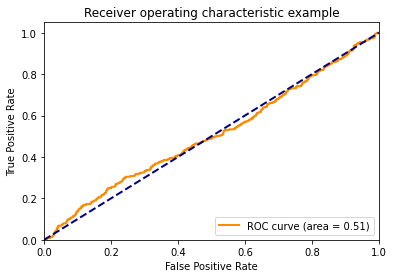

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()



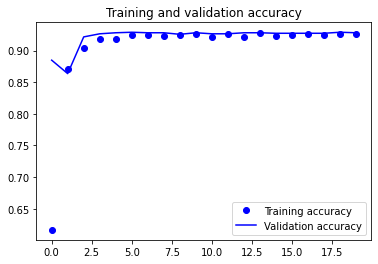

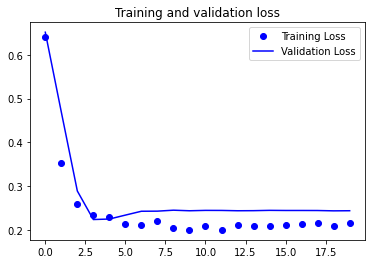

In [ ]:
plot_loss_acc(history)

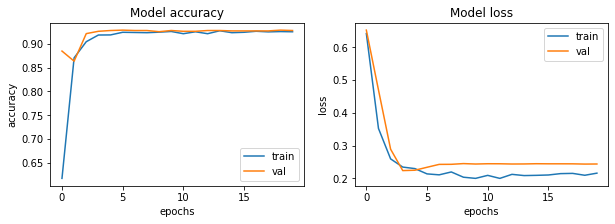

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is PNEUMONIA")
  else:
    print(fn + " is NORMAL")

Saving NORMAL (1).png to NORMAL (1).png
Saving NORMAL (2).png to NORMAL (2).png
Saving NORMAL (3).png to NORMAL (3).png
Saving NORMAL (4).png to NORMAL (4).png
Saving NORMAL (5).png to NORMAL (5).png
Saving NORMAL (6).png to NORMAL (6).png
Saving NORMAL (7).png to NORMAL (7).png
Saving NORMAL (8).png to NORMAL (8).png
Saving NORMAL (9).png to NORMAL (9).png
Saving NORMAL (10).png to NORMAL (10).png
Saving NORMAL (11).png to NORMAL (11).png
Saving NORMAL (12).png to NORMAL (12).png
Saving NORMAL (13).png to NORMAL (13).png
Saving NORMAL (14).png to NORMAL (14).png
Saving NORMAL (15).png to NORMAL (15).png
Saving NORMAL (16).png to NORMAL (16).png
Saving NORMAL (17).png to NORMAL (17).png
Saving NORMAL (18).png to NORMAL (18).png
Saving NORMAL (19).png to NORMAL (19).png
Saving NORMAL (20).png to NORMAL (20).png
Saving PNEUMONIA (1).png to PNEUMONIA (1).png
Saving PNEUMONIA (2).png to PNEUMONIA (2).png
Saving PNEUMONIA (3).png to PNEUMONIA (3).png
Saving PNEUMONIA (4).png to PNEUMONIA (4

In [ ]:
PNEUX_SAVED_MODEL = "pneux_saved_model"

tf.saved_model.save(model, PNEUX_SAVED_MODEL)

INFO:tensorflow:Assets written to: pneux_saved_model/assets


In [ ]:
%%bash -s $PNEUX_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 150, 150, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(PNEUX_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_1')})
{'dense_3': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense_3')}


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(PNEUX_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
saved_model_path = "./my_model.h5"


model.save(saved_model_path)
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

/bin/bash: tensorflowjs_converter: command not found


In [ ]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)
    
class_names = ['Normal', 'Pneumonia']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

    

In [ ]:
from google.colab import drive
drive.mount('drive')

!cp labels.txt "/content/drive/MyDrive/"
!cp converted_model.tflite "/content/drive/MyDrive"

Mounted at drive


In [5]:

interpreter = tf.lite.Interpreter(model_path="/content/gdrive/MyDrive/converted_model.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 150 150   3] <class 'numpy.float32'>

1 output(s):
[1 1] <class 'numpy.float32'>
